# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

План выполнения проекта:

Загрузим и подготовим данные.<br>
Обучим разные модели. Для каждой попробуйте различные гиперпараметры.<br>
Проанализируем скорость работы и качество моделей, применяя метрику RMSE.<br>


Признаки<br>
DateCrawled — дата скачивания анкеты из базы<br>
VehicleType — тип автомобильного кузова<br>
RegistrationYear — год регистрации автомобиля<br>
Gearbox — тип коробки передач<br>
Power — мощность (л. с.)<br>
Model — модель автомобиля<br>
Kilometer — пробег (км)<br>
RegistrationMonth — месяц регистрации автомобиля<br>
FuelType — тип топлива<br>
Brand — марка автомобиля<br>
NotRepaired — была машина в ремонте или нет<br>
DateCreated — дата создания анкеты<br>
NumberOfPictures — количество фотографий автомобиля<br>
PostalCode — почтовый индекс владельца анкеты (пользователя)<br>
LastSeen — дата последней активности пользователя<br>

Целевой признак<br>
Price — цена (евро)<br>

In [1]:
import pandas as pd
import numpy as np
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats as st
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, mean_absolute_error, make_scorer

from sklearn.pipeline import  make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor, Pool, cv
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OrdinalEncoder

import lime 
import lime.lime_tabular 


import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

## Подготовка данных

Изучим данные таблиц.

In [2]:
autos = pd.read_csv('/datasets/autos.csv')

In [3]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


Рассмотрим пропуски

In [4]:
autos.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

D таблице 354369 строк. Много пропусков в столбцах VehicleType, Gearbox, Model и NotRepaired. 


Рассмотрим, есть ли аномальные значения

In [5]:
autos.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Есть нулевые значения в графе "цена", год выпуска в периоде 1000-9999, аномальные цифры мощности свыше тысячи л.с. 

Уберем столбцы, которые не нужны для построения модели. 

Построим корреляции

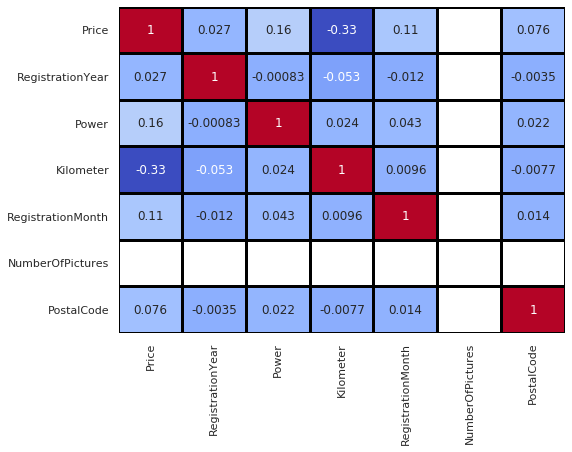

In [6]:
plt.figure(figsize=(8,6))
sns.heatmap(autos.corr(), annot = True, cmap='coolwarm',
            linecolor='black', linewidths=2, cbar=False)

Уберем столбцы DateCrawled, DateCreated, LastSeen, PostalCode. NumberOfPictures - пустой. RegistrationMonth практически не имеет связи с ценой и только утяжеляет модель. 

In [7]:
autos = autos.drop(['DateCrawled' , 'DateCreated', 'LastSeen', 'NumberOfPictures', 'RegistrationMonth', 'PostalCode'], axis=1)

Пересортируем оставшиеся

In [8]:
column_names = ['Brand','Model','VehicleType','RegistrationYear','Gearbox','Power','FuelType','Kilometer','NotRepaired','Price']
autos = autos.reindex(columns=column_names)

In [9]:
autos

,Brand,Model,VehicleType,RegistrationYear,Gearbox,Power,FuelType,Kilometer,NotRepaired,Price
0,volkswagen,golf,NaN,1993,manual,0,petrol,150000,NaN,480
1,audi,NaN,coupe,2011,manual,190,gasoline,125000,yes,18300
2,jeep,grand,suv,2004,auto,163,gasoline,125000,NaN,9800
3,volkswagen,golf,small,2001,manual,75,petrol,150000,no,1500
4,skoda,fabia,small,2008,manual,69,gasoline,90000,no,3600
...,...,...,...,...,...,...,...,...,...,...
354364,mitsubishi,colt,NaN,2005,manual,0,petrol,150000,yes,0
354365,sonstige_autos,NaN,NaN,2005,NaN,0,NaN,20000,NaN,2200
354366,smart,fortwo,convertible,2000,auto,101,petrol,125000,no,1199
354367,volkswagen,transporter,bus,1996,manual,102,gasoline,150000,no,9200


Посмотрим на распределения признаков. 

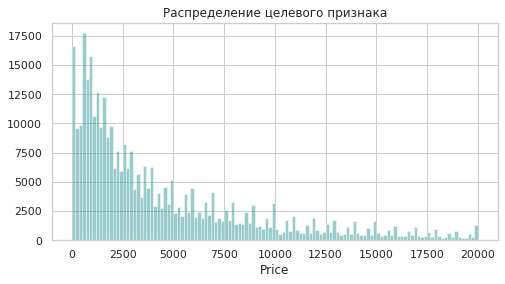

In [10]:
plt.figure(figsize=(8,4))
plt.title('Распределение целевого признака')
sns.distplot(autos['Price'], color="Teal", kde=False, bins=120)

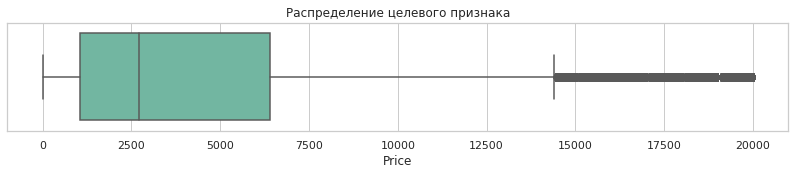

In [11]:
plt.figure(figsize=(14,2))
plt.title('Распределение целевого признака')
sns.boxplot(data=autos, x='Price', palette="Set2")

In [12]:
autos.sort_values(by = 'Price', ascending = False).head(10)

,Brand,Model,VehicleType,RegistrationYear,Gearbox,Power,FuelType,Kilometer,NotRepaired,Price
302739,volkswagen,passat,wagon,2011,auto,170,gasoline,150000,no,20000
315772,bmw,5er,sedan,2010,auto,184,gasoline,125000,no,20000
228640,mercedes_benz,c_klasse,sedan,2011,auto,265,gasoline,50000,no,20000
212039,mercedes_benz,c_klasse,sedan,2011,auto,265,gasoline,50000,no,20000
211999,audi,a1,small,2012,manual,143,gasoline,50000,no,20000
44271,sonstige_autos,NaN,NaN,2000,NaN,0,NaN,150000,NaN,20000
242045,volkswagen,golf,sedan,2014,auto,0,gasoline,30000,no,20000
128747,opel,astra,wagon,2014,manual,136,gasoline,40000,no,20000
332704,volkswagen,transporter,bus,2011,manual,140,gasoline,150000,no,20000
99684,audi,other,coupe,2008,auto,354,petrol,150000,no,20000


Нулевые значения следует убрать, а так же можно убрать цифру ровно в 20000 - скорее всего это опечатка, так как ни Гольф, ни Астра столько не стоит. 

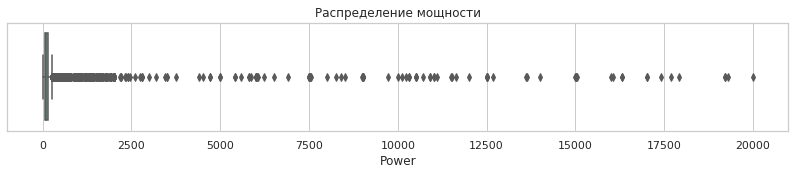

In [13]:
plt.figure(figsize=(14,2))
plt.title('Распределение мощности')
sns.boxplot(data=autos, x='Power', palette="Set2")

Очень большое количество выбросов, скорее всего ошибки в исходных данных. Обычная мощность автомобиля не превышает 350 л.с.

In [14]:
autos['Power'].value_counts()

0        40225
75       24023
60       15897
150      14590
101      13298
         ...  
16311        1
1360         1
1968         1
6226         1
6006         1
Name: Power, Length: 712, dtype: int64

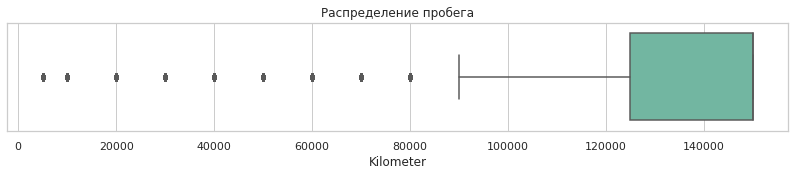

In [15]:
plt.figure(figsize=(14,2))
plt.title('Распределение пробега')
sns.boxplot(data=autos, x='Kilometer', palette="Set2")

In [16]:
autos = autos.query('20 < Power < 350')
autos = autos.query('10 < Price < 20000')
autos = autos.query('1950 < RegistrationYear < 2016')

In [17]:
autos['FuelType'].value_counts()

petrol      183300
gasoline     86652
lpg           4579
cng            474
hybrid         197
other           81
electric        35
Name: FuelType, dtype: int64

In [18]:
autos['VehicleType'].value_counts()

sedan          82412
small          69665
wagon          58968
bus            26133
convertible    18680
coupe          14355
suv            10799
other           2396
Name: VehicleType, dtype: int64

Обработаем пропуски. 
Model - удалим пустые модели

In [19]:
autos = autos.drop(autos[autos['Model'].isna()].index)

Удалим неизвестный тип топлива и неизвестную коробку передач, так как мы не сможем их восстановить. 
Кстати, gasolin и petrol - синонимы, дизельное топливо (diesel) отдельно не указано, а типы газового топлива не так важны для модели и по-хорошему стоило бы их объединить. 

In [20]:
autos = autos.drop(autos[autos['Gearbox'].isna()].index)
autos = autos.drop(autos[autos['FuelType'].isna()].index)

NotRepaired - была машина в ремонте или нет <br>

Столбец может быть не заполнен, так как машина в ремонте не была. Но может быть он не заполнен специально, так как владельцы желают скрыть эту информацию. <br>

Предлагаю ввести третий тип данных, кроме "да" и "нет" - "unknown".<br>

In [21]:
autos['NotRepaired'].fillna('unknown', inplace=True)

VehicleType - тип кузова. <br>
Проще всего пустые значения тоже выкинуть, но можно и восстановить их по известным нам моделям. <br>
Создадим словарик самого популярного типа кузова в рамках одной модели. 

In [22]:
dict_vehicle =  (autos
#.query('Model == "a4"')                 
.pivot_table(index=['Brand', 'Model',  'VehicleType'], values= 'Price', aggfunc = {'Price':'count'})
.reset_index()               
).sort_values( by = ['Brand', 'Model',  'Price'], ascending = False)
dict_vehicle.set_axis(['Brand','Model','VehicleType','Count'], axis = 'columns', inplace = True) 
dict_vehicle = dict_vehicle.groupby(['Brand', 'Model']).agg('first').reset_index()
dict_vehicle.head(15)

,Brand,Model,VehicleType,Count
0,alfa_romeo,145,small,18
1,alfa_romeo,147,sedan,338
2,alfa_romeo,156,wagon,262
3,alfa_romeo,159,wagon,138
4,alfa_romeo,other,coupe,167
5,alfa_romeo,spider,convertible,157
6,audi,100,sedan,240
7,audi,200,sedan,13
8,audi,80,sedan,791
9,audi,90,sedan,62


Заменим пустые значения на найденный кузов

In [23]:
autos['car'] = autos['Brand']+'_'+autos['Model']
dict_vehicle['car'] = dict_vehicle['Brand']+'_'+dict_vehicle['Model']
autos['VehicleType_new'] = autos['car'].map(dict_vehicle.set_index(['car'])['VehicleType'])
#заполним NaN
autos['VehicleType'].fillna(autos['VehicleType_new'], inplace=True)
autos = autos.drop(['VehicleType_new', 'car'], axis=1)

В целом данные по типу кузова содержат множество ошибок, например Nissan Micra в кузове "bus" и прочее, но их процент не такой значительный. 

In [24]:
autos.isnull().sum()

Brand               0
Model               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
FuelType            0
Kilometer           0
NotRepaired         0
Price               0
dtype: int64

Дубликаты. А нужно ли их удалять или нет? 

In [25]:
autos.duplicated().sum()

37816

## Обучение моделей

Построим четыре модели - (две градиентного бустинга и две простых модели регрессии) для определения стоимости и сравним метрики и время обучения. 

Создадим переменные для признаков и целевого признака.

In [26]:
features = autos.drop(['Price'], axis=1)
target = autos['Price']

Разобьем датасет на обучающую и тестовую выборку в соотношении 80-20

In [27]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)

print('Размер обучающей выборки:', len(features_train))
print('Размер тестовой выборки:', len(features_test))

Размер обучающей выборки: 211203
Размер тестовой выборки: 52801


Табличка для записи

In [29]:
d = {'': ['RMSE', 'Время обучения', 'Время предсказания']}
summary_table = pd.DataFrame(data=d)

def write_summary_table (col):
    summary_table.loc[0, col] = rms
    summary_table.loc[1, col] = fit_end - fit_start
    summary_table.loc[2, col] = pred_end - pred_start

### CatBoost ###

Выделим категориальные признаки

In [30]:
cat_features = features_train.select_dtypes(include='object').columns
cat_features

Index(['Brand', 'Model', 'VehicleType', 'Gearbox', 'FuelType', 'NotRepaired'], dtype='object')

In [31]:
model = CatBoostRegressor(random_seed=12345, cat_features=cat_features)

parameters = {
    'loss_function': ['RMSE'],
    'learning_rate': np.logspace(-1, 0, 5),
    'iterations': [100], #[40, 60, 100, 200, 500]
    'depth': [7],  #[5, 7, 10] 
    'verbose': [200]

}
grid_CatBoost = GridSearchCV(model, parameters, scoring = 'neg_mean_squared_error', cv = 3)
grid_CatBoost.fit(features_train, target_train, cat_features=cat_features) 

rms = np.sqrt(-1 *grid_CatBoost.best_score_)
print("RMSE наилучшей модели:", rms)
print(grid_CatBoost.best_params_)
print(grid_CatBoost.best_estimator_)


0:	learn: 4296.7395676	total: 176ms	remaining: 17.4s
99:	learn: 1665.2014304	total: 16.7s	remaining: 0us
0:	learn: 4291.7876400	total: 34.2ms	remaining: 3.39s
99:	learn: 1671.4709763	total: 16.3s	remaining: 0us
0:	learn: 4295.2088217	total: 25.2ms	remaining: 2.49s
99:	learn: 1676.6176297	total: 16.3s	remaining: 0us
0:	learn: 4050.2231087	total: 26.2ms	remaining: 2.59s
99:	learn: 1609.2947312	total: 16.3s	remaining: 0us
0:	learn: 4046.6333088	total: 64.6ms	remaining: 6.4s
99:	learn: 1605.0154406	total: 16.3s	remaining: 0us
0:	learn: 4049.4536446	total: 21.1ms	remaining: 2.08s
99:	learn: 1611.6120146	total: 16s	remaining: 0us
0:	learn: 3633.7326927	total: 67.7ms	remaining: 6.7s
99:	learn: 1552.5643523	total: 16.2s	remaining: 0us
0:	learn: 3632.6136711	total: 101ms	remaining: 10s
99:	learn: 1556.5478101	total: 16.8s	remaining: 0us
0:	learn: 3634.3556470	total: 56.6ms	remaining: 5.61s
99:	learn: 1558.0928011	total: 16.2s	remaining: 0us
0:	learn: 2993.9725962	total: 31.3ms	remaining: 3.1s
9

In [32]:
%%time

fit_start = time.time()
grid_CatBoost.best_estimator_.fit(features_train, target_train)
fit_end = time.time()

pred_start = time.time()

predicted_test = grid_CatBoost.predict(features_test)
mse = mean_squared_error(target_test, predicted_test)
pred_end = time.time()


rms = mse ** 0.5
write_summary_table('CatBoost')
print("RMSE =", rms)


0:	learn: 3014.7294533	total: 210ms	remaining: 20.8s
99:	learn: 1519.9205368	total: 22.6s	remaining: 0us
RMSE = 1550.3110886609416
CPU times: user 20.4 s, sys: 2.9 s, total: 23.3 s
Wall time: 24.5 s


### LightGBM ###

Перекодируем категориальные признаки с помощью метода OrdinalEncoder

In [33]:
enc = OrdinalEncoder()
enc.fit(features_train[cat_features])
features_train[cat_features] = enc.transform(features_train[cat_features])

In [34]:
enc.fit(features_test[cat_features])
features_test[cat_features] = enc.transform(features_test[cat_features])


In [35]:
%%time

start = time.time()
model = LGBMRegressor()

parameters = {
    'boosting_type':['gbdt'],
    'learning_rate': np.logspace(-1, 0, 3),
    'n_estimators': [150], #[40, 60, 100, 150, 200],
    'loss_function': ['RMSE']
    
}
grid_LGBM = GridSearchCV(model, parameters, scoring = 'neg_mean_squared_error', cv = 3)
grid_LGBM.fit(features_train, target_train)
end = time.time()

rms = np.sqrt(-1 *grid_LGBM.best_score_)
print("RMSE наилучшей модели:", rms)
print(grid_LGBM.best_params_)
print(grid_LGBM.best_estimator_)
print(end-start)

RMSE наилучшей модели: 1542.9377119522544
{'boosting_type': 'gbdt', 'learning_rate': 0.31622776601683794, 'loss_function': 'RMSE', 'n_estimators': 150}
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.31622776601683794,
              loss_function='RMSE', max_depth=-1, min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=150,
              n_jobs=-1, num_leaves=31, objective=None, random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)
90.3149778842926
CPU times: user 1min 29s, sys: 0 ns, total: 1min 29s
Wall time: 1min 30s


In [36]:
%%time

fit_start = time.time()
grid_LGBM.best_estimator_.fit(features_train, target_train)
fit_end = time.time()

pred_start = time.time()
predicted_test = grid_LGBM.predict(features_test)
mse = mean_squared_error(target_test, predicted_test)
pred_end = time.time()

rms = mse ** 0.5
write_summary_table('LightGBM')
print("RMSE =", rms)

RMSE = 1582.3406114823879
CPU times: user 23.8 s, sys: 0 ns, total: 23.8 s
Wall time: 24 s


### DecisionTreeRegressor ###

In [37]:
model = DecisionTreeRegressor()

parameters = {'max_depth': range(1,16,2)}

grid_DecisionTree = GridSearchCV(model, parameters, scoring = 'neg_mean_squared_error', cv = None)
grid_DecisionTree.fit(features_train, target_train)


rms = np.sqrt(-1 *grid_DecisionTree.best_score_)
print("RMSE наилучшей модели:", rms)
print(grid_DecisionTree.best_params_)
print(grid_DecisionTree.best_estimator_)



RMSE наилучшей модели: 1805.9693229197499
{'max_depth': 15}
DecisionTreeRegressor(criterion='mse', max_depth=15, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')


In [38]:
%%time

fit_start = time.time()
grid_DecisionTree.best_estimator_.fit(features_train, target_train)
fit_end = time.time()

pred_start = time.time()
predicted_test = grid_DecisionTree.predict(features_test)
mse = mean_squared_error(target_test, predicted_test)
pred_end = time.time()

rms = mse ** 0.5
write_summary_table ('DecisionTreeRegressor')
print("RMSE =", rms)

RMSE = 1819.9954578228421
CPU times: user 503 ms, sys: 0 ns, total: 503 ms
Wall time: 509 ms


### LinearRegression ###

In [39]:
model = LinearRegression()

parameters = {'normalize': [True, False]}

grid_LinearRegression = GridSearchCV(model, parameters, scoring = 'neg_mean_squared_error', cv = 5)
grid_LinearRegression.fit(features_train, target_train)

rms = np.sqrt(-1 *grid_LinearRegression.best_score_)

print("RMSE наилучшей модели:", rms)
print(grid_LinearRegression.best_params_)
print(grid_LinearRegression.best_estimator_)

RMSE наилучшей модели: 2829.9765314150654
{'normalize': True}
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)


In [40]:
%%time

fit_start = time.time()
grid_LinearRegression.best_estimator_.fit(features_train, target_train)
fit_end = time.time()

pred_start = time.time()
predicted_test = grid_LinearRegression.predict(features_test)
mse = mean_squared_error(target_test, predicted_test)
pred_end = time.time()

rms = mse ** 0.5
write_summary_table ('LinearRegression')
print("RMSE =", rms)


RMSE = 2820.123592147942
CPU times: user 67.5 ms, sys: 84.8 ms, total: 152 ms
Wall time: 169 ms


## Анализ моделей

In [41]:
summary_table

,,CatBoost,LightGBM,DecisionTreeRegressor,LinearRegression
0,RMSE,1550.311089,1582.340611,1819.995458,2820.123592
1,Время обучения,24.464126,23.492470,0.494027,0.104789
2,Время предсказания,0.077756,0.488794,0.012671,0.003252


Мы исследовали баланс классов, построили, обучили и протестировали три модели: модели градиентного бустинга CatBoost, LightGBM, модели решающее дерево и линейную регрессию, а так же измерили метрику RMSE и время обучения и предсказания. <br> 

Модели градиентного бустинга показали лучшие результаты, чем простые модели, однако на этапе подбора параметров  обучаются они очень медленно. <br>
Можно заметить, что качество моделей градиентного бустинга прямо зависит от числа итераций - чем больше итераций, тем лучше качество, но тем медленнее обучается модель. <br>

Среди простых моделей хуже всего метрика RMSE у линейной регрессии, но обучается она максимально быстро. 


**График важности факторов**

(возьмем модель LightGBM, чтобы не возвращать обратно категориальные признаки)

In [101]:
model = grid_LGBM
model.best_estimator_.fit(features_train, target_train)


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.31622776601683794,
              loss_function='RMSE', max_depth=-1, min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=150,
              n_jobs=-1, num_leaves=31, objective=None, random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [103]:
importances = model.best_estimator_.feature_importances_
feature_list = list(features_train.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False)
feature_results.head(10)

,feature,importance
3,RegistrationYear,1062
5,Power,1043
1,Model,712
0,Brand,557
7,Kilometer,417
2,VehicleType,354
6,FuelType,131
8,NotRepaired,122
4,Gearbox,102


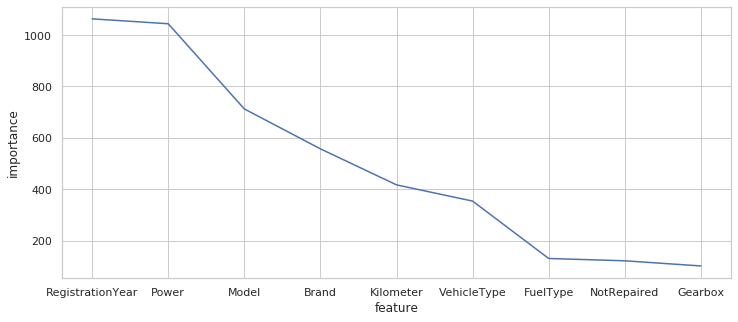

In [104]:
plt.figure(figsize=(12,5))
sns.lineplot(x = 'feature', y = 'importance', data= feature_results, sort=False) 

Больше всего влияют на стоимость год выпуска и мощность. 

Посмотрим на самые большие расхождения в предсказания и реальной стоимости

Предсказание: 19286.7144
Факт: 217.0000
Brand                 nissan
Model                qashqai
VehicleType              suv
RegistrationYear        2015
Gearbox               manual
Power                    130
FuelType            gasoline
Kilometer              10000
NotRepaired               no
Price                    217
Name: 263785, dtype: object

Предсказание: 18878.2225
Факт: 359.0000
Brand                    bmw
Model                    3er
VehicleType            sedan
RegistrationYear        2013
Gearbox               manual
Power                    184
FuelType            gasoline
Kilometer              40000
NotRepaired               no
Price                    359
Name: 42957, dtype: object



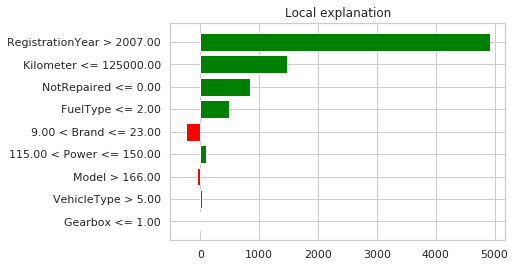

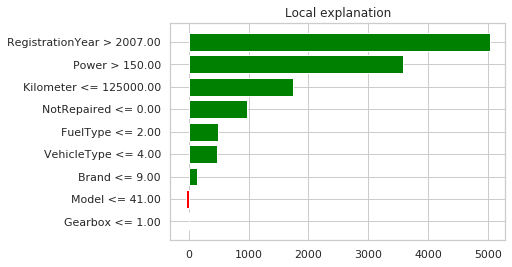

In [106]:
model_pred = model.predict(features_test)
model_pred = pd.Series(model_pred, index=features_test.index)   

residuals = abs(model_pred - target_test)

residuals = residuals.sort_values(ascending = False).head(2)

for idx in residuals.index:
     
    wrong = features_test.loc[idx, :]
    print('Предсказание: %0.4f' % model_pred[idx])
    print('Факт: %0.4f' % target_test[idx])
    print(autos.loc[idx, :])
    explainer = lime.lime_tabular.LimeTabularExplainer(features_train.to_numpy(), mode = 'regression', training_labels = target_train, feature_names = feature_list)
    exp = explainer.explain_instance(data_row = wrong, predict_fn = model.predict)
    exp.as_pyplot_figure()
    print('')
    


Qashqai 2015 года и bmw 3er 2013 модель оценила высоко с учетом их года выпуска, мощности, пробега и отсутствия ремонта, но их фактическая цена сильно ниже. Возможно в объявлении указано далеко не все. 